<h1>Week-8 Homework</h1>
<h3>Title: Exercise 10.1</h3>
Using the data from the BRFSS, compute the linear least squares fit for log(weight) versus height. How would you best present the
estimated parameters for a model like this where one of the variables is log-transformed? If you were trying to guess someone’s weight, how much would it help to know their height?<br/>
Like the NSFG, the BRFSS oversamples some groups and provides a sampling weight for each respondent. In the BRFSS data, the variable name for these weights is finalwt. Use resampling, with and without weights, to estimate the mean height of respondents in the BRFSS, the standard error of the mean, and a 90% confidence interval. How much does correct weighting affect the estimates?

<h3>Import libraries</h3>

In [1]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
from IPython.display import set_matplotlib_formats

import brfss
import thinkplot
import thinkstats2

set_matplotlib_formats("png", "pdf")
plt.rcParams["figure.figsize"] = [8, 6]

<h3>Load dataset</h3> 
Get height and log(weight)


In [2]:
df = brfss.ReadBrfss(nrows=None)
df = df.dropna(subset=["htm3", "wtkg2"])
heights, weights = df.htm3, df.wtkg2
log_weights = np.log10(weights)

In [3]:
inter, slope = thinkstats2.LeastSquares(heights, log_weights)
print("Intercept:%0.3f and slope:%0.3f" % (inter, slope))

Intercept:0.993 and slope:0.005


Make a scatter plot of the data and show the fitted line .

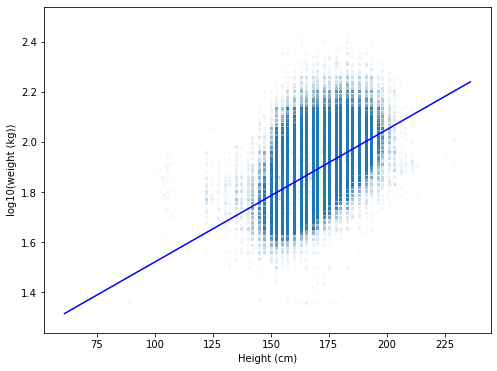

In [4]:
plt.scatter(heights, log_weights, alpha=0.02, s=5)
xfit = np.sort(heights)
yfit = inter + slope * xfit
plt.plot(xfit, yfit, color="blue")
plt.xlabel("Height (cm)")
plt.ylabel("log10(weight (kg))")
plt.show()

Make the same plot but apply the inverse transform to show weights on a linear (not log) scale.

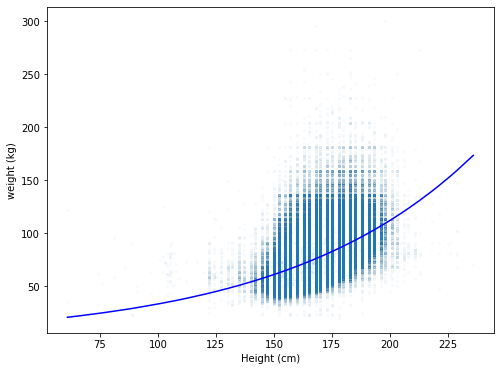

In [5]:
plt.scatter(heights, weights, alpha=0.02, s=5)
xfit = np.sort(heights)
yfit = inter + slope * xfit
plt.plot(xfit, 10 ** yfit, color="blue")
plt.xlabel("Height (cm)")
plt.ylabel("weight (kg)")
plt.show()

Plot percentiles of the residuals.

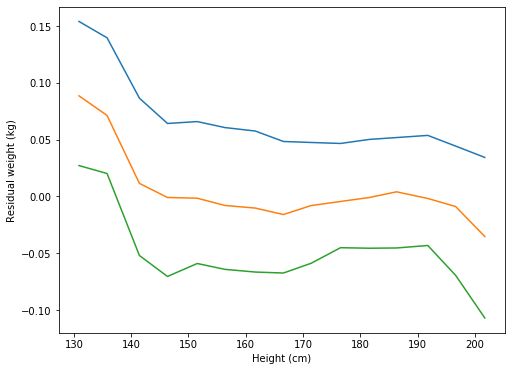

In [6]:
res = thinkstats2.Residuals(heights, log_weights, inter, slope)
df["residual"] = res

bins = np.arange(130, 210, 5)
indices = np.digitize(df.htm3, bins)
groups = df.groupby(indices)

means = [group.htm3.mean() for i, group in groups][1:-1]
cdfs = [thinkstats2.Cdf(group.residual) for i, group in groups][1:-1]

for percent in [75, 50, 25]:
    ys = [cdf.Percentile(percent) for cdf in cdfs]
    label = "%dth" % percent
    plt.plot(means, ys, label=label)
    plt.xlabel("Height (cm)")
    plt.ylabel("Residual weight (kg)")
plt.show()

Compute correlation.

In [8]:
rho = thinkstats2.Corr(heights, log_weights)
print("Correlation between Height and log10(weight): %0.3f" % (rho))

Correlation between Height and log10(weight): 0.532


Compute coefficient of determination and confirm that $R^2 = \rho^2$.

In [9]:
r2 = thinkstats2.CoefDetermination(log_weights, res)
print("Coefficient of determination: %0.3f" % (r2))

print("R^2 - r^2: %0.4d" % (rho ** 2 - r2))

Coefficient of determination: 0.283
R^2 - r^2: 0000


Compute Std(ys), which is the RMSE of predictions that don't use height.

In [10]:
std_ys = thinkstats2.Std(log_weights)
print("Std(ys): %0.3f" % (std_ys))

Std(ys): 0.103


Compute Std(res), the RMSE of predictions that do use height.

In [11]:
std_res = thinkstats2.Std(res)
print("Std(res): %0.3f" % (std_res))

Std(res): 0.087


Find how much height information reduce RMSE.

In [12]:
print("Impact of height on RMSE: %0.3f" % (1 - std_res / std_ys))

Impact of height on RMSE: 0.153


Use resampling to compute sampling distributions for inter and slope.

In [13]:
t = []
for _ in range(100):
    sample = thinkstats2.ResampleRows(df)
    estimates = thinkstats2.LeastSquares(sample.htm3, np.log10(sample.wtkg2))
    t.append(estimates)

inters, slopes = zip(*t)

Plot the sampling distribution of slope.

{'xscale': 'linear', 'yscale': 'linear'}

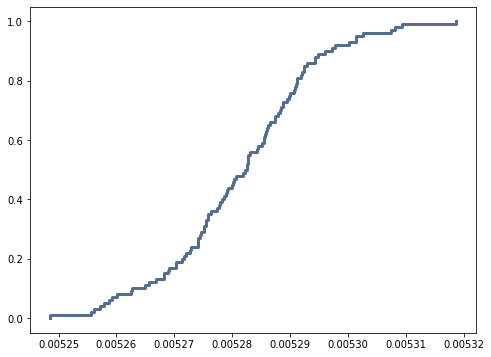

In [14]:
cdf = thinkstats2.Cdf(slopes)
thinkplot.Cdf(cdf)

Compute the p-value of the slope.

In [14]:
pvalue = cdf[0]
print("P-value of slope: %0.3f" % (pvalue))

P-value of slope: 0.000


Compute the 90% confidence interval of slope.

In [15]:
ci = cdf.Percentile(5), cdf.Percentile(95)
print("Confidence interval for 90%%: %0.5f and %0.5f " % (ci))

Confidence interval for 90%: 0.00526 and 0.00531 


Compute the mean of the sampling distribution.

In [16]:
mean = thinkstats2.Mean(slopes)
print("Mean of sampling distribution: %0.5f" % (mean))

Mean of sampling distribution: 0.00528


Compute the standard deviation of the sampling distribution, which is the standard error.

In [17]:
stderr = thinkstats2.Std(slopes)
print("Standard error: %0.5f" % (stderr))

Standard error: 0.00001


Resample rows without weights, compute mean height, and summarize results.

In [18]:
from thinkstats2 import Cov, Mean, MeanVar, Std, Var


def Summarize(estimates, actual=None):
    mean = Mean(estimates)
    stderr = Std(estimates, mu=actual)
    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.ConfidenceInterval(90)
    print("Mean: %0.4f, SE:%0.4f" % (mean, stderr))
    print("CI: %0.4f to %0.4f" % (ci))


estimates_unweighted = [thinkstats2.ResampleRows(df).htm3.mean() for _ in range(100)]
Summarize(estimates_unweighted)

Mean: 168.9556, SE:0.0181
CI: 168.9238 to 168.9854


Resample rows with weights(`finalwt`).

In [19]:
def ResampleRowsWeighted(df, column="finalwgt"):
    weights = df[column]
    cdf = thinkstats2.Cdf(dict(weights))
    indices = cdf.Sample(len(weights))
    sample = df.loc[indices]
    return sample


estimates_weighted = [
    ResampleRowsWeighted(df, "finalwt").htm3.mean() for _ in range(100)
]
Summarize(estimates_weighted)

Mean: 170.4984, SE:0.0173
CI: 170.4667 to 170.5244


The mean height is around 2cm taller when sampling weights considered. The difference in mean height is much bigger than standard error. 